# Random Forest Supervised Classification

This script utilizes the training data generated in the previous script as an input into the Random
Forest Classifier in scikit-learn. We first read in the entire Landsat and training images as arrays, 
then reshape them to the proper 2-D required by scikit-learn. We then fit the RFC classifier to the 
training dataset, using the band combinations for each known pixel label as the X and the known labels
as y. We then predict labels for the entire Landsat dataset and write the output classes to a given 
GeoTIFF path. 

In [1]:
import geopandas as gpd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal, osr

from dask.distributed import Client
import joblib

%matplotlib inline

Reads in the entire Landsat image and the input training image generated in the previous script.

In [2]:
in_whole_image = r"../../data/austin_clipped_landsat/Austin_Landsat_Clip_2015.tif"
# in_whole_image = r"../../data/austin_clipped_landsat/Austin_Landsat_Clip_2020.tif"

in_train_image = r"../../data/austin_training_datasets/Austin_Training_Classes_2015.tif"
# in_train_image = r"../../data/austin_training_datasets/Austin_Training_Classes_2020.tif"

out_tif = r"../../data/austin_rfc_classifications/Austin_RFC_Class_2015.tif"
# out_tif = r"../../data/austin_rfc_classifications/Austin_RFC_Class_2020.tif"


in_whole_ds = gdal.Open(in_whole_image)
arr_list =[]
for i in range(1, in_whole_ds.RasterCount +1):
    band = in_whole_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_whole_data = np.dstack(np.array(arr_list))
in_whole_data.shape

in_train_ds = gdal.Open(in_train_image)
arr_list = []
for i in range(1, in_train_ds.RasterCount + 1):
    band = in_train_ds.GetRasterBand(i)
    arr = band.ReadAsArray()
    arr_list.append(arr)
in_train_data = np.dstack(np.array(arr_list))

Plotting Training dataset vs Clipped Landsat Image

Text(0.5, 1.0, 'Travis County Landsat Clipped Image')

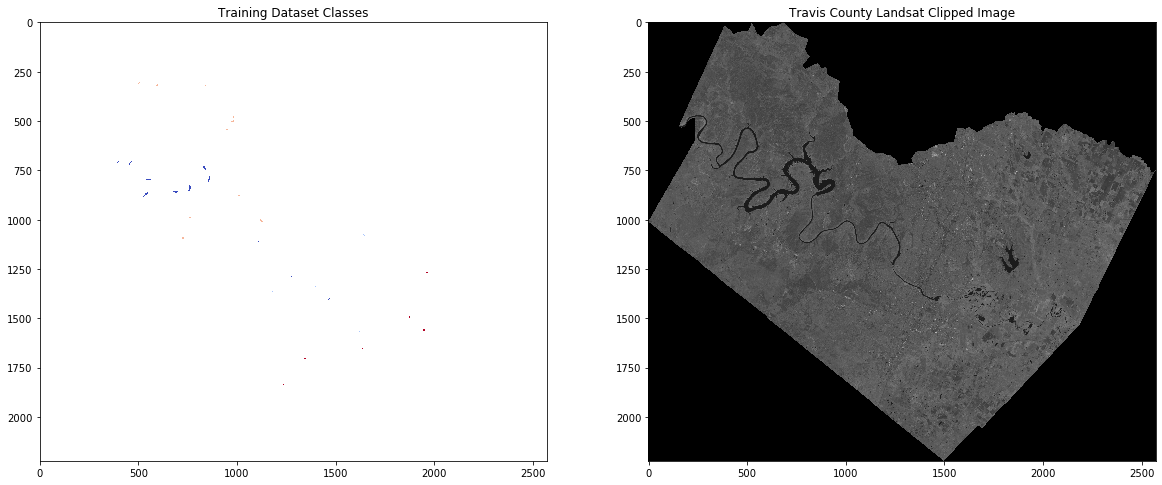

In [3]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,10))

plot_train_data = in_train_data.copy()
plot_train_data[plot_train_data==0]=np.nan

ax[0].imshow(plot_train_data[:,:,0], cmap='coolwarm')
ax[0].set_title('Training Dataset Classes')

ax[1].imshow(in_whole_data[:,:,3], cmap=plt.cm.Greys_r)
ax[1].set_title('Travis County Landsat Clipped Image')

In [4]:
print("Shape of Landsat array: {}".format(in_whole_data.shape))
print("Shape of training dataset: {}".format(in_train_data.shape))

Shape of Landsat array: (2223, 2572, 4)
Shape of training dataset: (2223, 2572, 1)


Next, mask the input Landsat image to the extent of the training raster. Also including 0 values as a class

In [5]:
arr_list = []
for i in range(in_whole_data.shape[2]):
    out_arr = np.append(in_whole_data[:,:,i][in_train_data[:,:,0]>0], 
                        in_whole_data[in_whole_data[:,:,0]==0])
    arr_list.append(out_arr)

X = np.array(arr_list)
y = np.append(in_train_data[in_train_data>0], 
             in_whole_data[in_whole_data[:,:,0]==0])
pred_data = in_whole_data.reshape(-1,in_whole_data.shape[2])

Fit and predict on the Random Forest Classifier. I am using dask in an attempt to parallelize the 
processing, but haven't gotten around to really prodding yet

In [6]:
client = Client()
with joblib.parallel_backend('dask'):
    rfc = RandomForestClassifier(n_estimators=50, oob_score=True).fit(X.T,
                                                                  y.flatten())
    preds = rfc.predict(pred_data)

Now we've actually ran a supervised classification scheme in sklearn!

Text(0.5, 1.0, 'RFC Results')

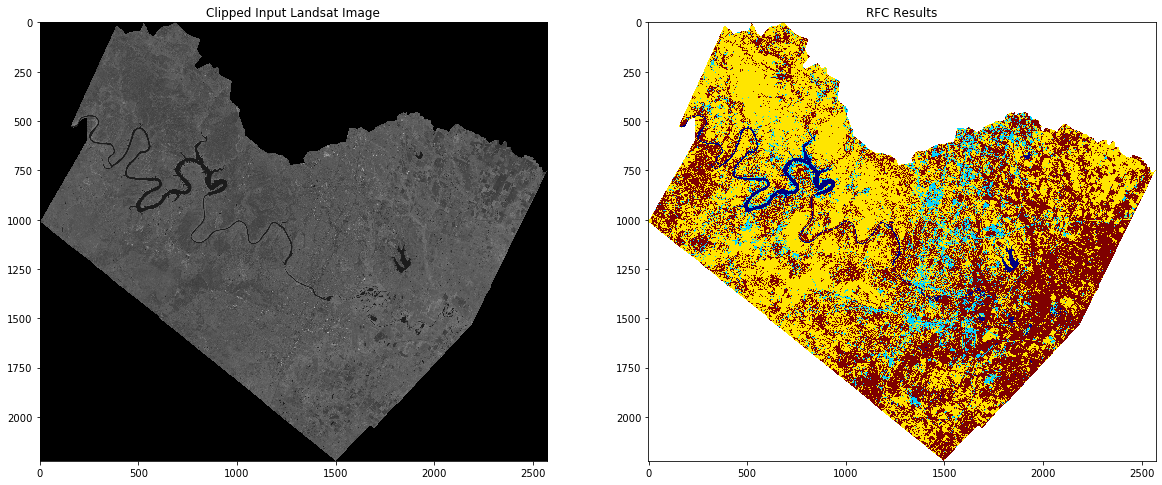

In [7]:
labels = preds.reshape((in_whole_data.shape[0], in_whole_data.shape[1]))
plot_labels = labels.copy()
plot_labels[plot_labels==0] = np.nan

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].imshow(in_whole_data[:,:,3], cmap=plt.cm.Greys_r)
ax[0].set_title('Clipped Input Landsat Image')

ax[1].imshow(plot_labels, cmap='jet')
ax[1].set_title('RFC Results')

Writing the outputs to a Geotiff:

In [8]:
tif_driver = gdal.GetDriverByName("GTiff")
in_gt = in_whole_ds.GetGeoTransform()
in_prj = in_whole_ds.GetProjection()

in_srs = osr.SpatialReference(wkt=in_prj)

out_tif = tif_driver.Create(out_tif, 
                            in_whole_data.shape[1],
                            in_whole_data.shape[0],
                            1,
                            gdal.GDT_Float64)



out_tif.SetProjection(in_srs.ExportToWkt())
out_tif.SetGeoTransform(in_gt)
out_band = out_tif.GetRasterBand(1)
out_band.WriteArray(labels)
out_tif.FlushCache()